In [1]:
# WikiRoute is a simple program that plans your commute with interesting geocoded wikipedia locations along the way!

In [93]:
def WikiRoute(startpoint,endpoint,bufferdistance):
    #import everything
    import geopy
    from geopy import distance
    import wikipedia
    import pandas as pd
    import numpy as np
    import osmnx as ox
    import networkx as nx
    from sklearn.neighbors import KDTree
    import matplotlib.pyplot as plt
    %matplotlib inline
    import geopandas as gpd
    from shapely.geometry import Point
    import datetime
    from IPython.display import IFrame
    ox.config(log_console=True, use_cache=True)
    starttime = datetime.datetime.now().strftime("%d-%m-%y_%H-%M")
    #midpoint calculation
    midpoint = (((startpoint[0]+endpoint[0])/2),((startpoint[1]+endpoint[1])/2))

    #radius calculation
    radius = geopy.distance.vincenty(startpoint, endpoint).m

    #OSM network pull
    G = ox.graph_from_point(midpoint, distance=radius)
    ox.utils.add_edge_bearings(G)
    #define node/edge dfs
    nodes, edges= ox.graph_to_gdfs(G)
    nodes['x_float'] = nodes['x'].astype(float)
    nodes['y_float'] = nodes['y'].astype(float)
    nodes['osm_float'] = nodes['osmid'].astype(float)
    edges['u_v'] = edges['u'].astype(str) + '_' + edges['v'].astype(str)
    #Closest network nodes to start/end points
    tree = KDTree(nodes[['y', 'x']], metric='euclidean')
    start_idx = tree.query([startpoint], k=1, return_distance=False)[0]
    end_idx = tree.query([endpoint], k=1, return_distance=False)[0]
    closest_node_to_start = nodes.iloc[start_idx].index.values[0]
    closest_node_to_end = nodes.iloc[end_idx].index.values[0]

    #creates original best route from start-end nodes
    route = nx.shortest_path(G, closest_node_to_start, closest_node_to_end)

    #filters to only nodes along route and buffers to capture the possible path deviations
    routestr = []
    for osmid in route:
        routestr.append(str(osmid))
    nodes['routepath'] = nodes['osmid'].isin(routestr)
    crs = {'init': 'epsg:4326'}
    pathbuffer = gpd.GeoDataFrame(nodes[nodes['routepath']==True], crs=crs)
    pathbuffer = pathbuffer.to_crs(epsg=3857)
    pathbuffer = pathbuffer.buffer(bufferdistance)
    pathbuf2 = gpd.GeoDataFrame(nodes[nodes['routepath']==True], geometry=pathbuffer)
    pathbuf2 = pathbuf2.set_geometry('geometry')
    pathbuf2['yx'] = zip(pathbuf2['y'],pathbuf2['x'])
    #wikipedia places scrape
    places = []
    for y,x in zip(list(pathbuf2['y']),list(pathbuf2['x'])):
        places = places + wikipedia.geosearch(y,x, results=10000, radius=bufferdistance)
    places = list(set(places))
    #Place-Geocode orginization
    placedict = {}
    for place in places:
        placedict[place]=wikipedia.WikipediaPage(place).coordinates

    #Reformats wikipedia attractions
    wikilocations = gpd.GeoDataFrame.from_dict(placedict,orient='index',columns=['y','x']).reset_index()
    wikilocations['coord'] = [Point(xy) for xy in zip(wikilocations['x'],wikilocations['y'])]
    wikilocations['yxwiki'] = zip(wikilocations['y'],wikilocations['x'])
    wikilocations2 = gpd.GeoDataFrame(wikilocations, crs=crs)
    wikilocations2['geometry'] = wikilocations2['coord']
    wikilocations2 = wikilocations2.set_geometry('geometry')
    wikilocations2 = wikilocations2.to_crs(epsg=3857)
    #finds the attractions along the route
    wikilocations_route = gpd.sjoin(wikilocations2,pathbuf2, how="inner", op="within")
    #sequences order of nodes along original route
    route_sequence = {}
    counter = 0
    for i in route:
        route_sequence[counter] = i
        counter += 1

    #finds the network nodes closest to attractions 
    wikilocations_route['xyloc'] = zip(wikilocations_route['y_right'],wikilocations_route['x_right'])
    wikilocations_route['att_route_dist'] = wikilocations_route.apply(lambda column: geopy.distance.vincenty(column['yxwiki'], column['yx']).m,axis=1)
    wikilocations_route = wikilocations_route.sort_values('att_route_dist', ascending=True)
    wikilocations_route = wikilocations_route.drop_duplicates(subset=['index'],keep='first')
    attractionNodes = {}
    for place, routecoord, coord in zip(list(wikilocations_route['index']),list(wikilocations_route['osmid']),list(wikilocations_route['xyloc'])):
        attractionNodes[place] = [int(routecoord),nodes.iloc[tree.query([coord], k=1, return_distance=False)[0]].index.values[0]]
    attraction_node_ordered = {}
    for key, value in attractionNodes.items():
        route_pos = value[0]
        attr_node = value[1]
        attr_name = key
        for key,value in route_sequence.items():
            if value == route_pos:
                attraction_node_ordered[key] = attr_node,attr_name
    #Creates routes based on wikipedia attractions
    nodeA = closest_node_to_start
    routes = []
    attractions = []
    for i in sorted(attraction_node_ordered.keys()):
        nodeB = attraction_node_ordered[i][0]
        attraction = attraction_node_ordered[i][1]
        attractions.append(attraction)
        routes.append(nx.shortest_path(G, nodeA, nodeB))
        nodeA = nodeB
    routes.append(nx.shortest_path(G, nodeA, closest_node_to_end))
    #plots sections of route in order
    for routeseg, place in zip(routes,attractions):
        if len(routeseg)>1:
            NodeAttractions = []
            for i in attractionNodes.keys():
                if attractionNodes[i][1] == routeseg[-1]:
                    NodeAttractions.append(i)
            segment_dict = {}
            i = 0
            for node in routeseg:
                segment_dict[i] = [str(node)]
                i = i + 1
            listed = {}
            a = 0
            for key,value in segment_dict.items():
                if key+1 <= max(segment_dict.keys()):
                    df = edges[edges['u_v'] == str(segment_dict[key][0]) + '_' + str(segment_dict[key+1][0])]
                    listed[a] = [df['v'].item(), df['bearing'].item(), df['length'].item(), df['name'].item()]
                    a = a + 1
            b = 0
            distance = listed[b][2]
            if listed[b][1] <= 40:
                NESW = "North"
            elif listed[b][1] <= 140:
                NESW = "East"
            elif listed[b][1] <= 180:
                NESW = "South"
            elif listed[b][1] <= 220:
                NESW = "South"
            elif listed[b][1] <= 320:
                NESW = "West"
            elif listed[b][1] <= 360:
                NESW = "North"
            print("Head " + NESW + " onto " + str(listed[b][3]))
            while b<max(listed.keys()):
                if (listed[b][3] == listed[b+1][3]) or (int(listed[b][1]) == int(listed[b+1][1])):
                    distance += listed[b][2]
                else:
                    distance += listed[b][2]
                    if listed[b+1][1] - listed[b][1] > 0:
                        turn_deg = (listed[b+1][1] - listed[b][1])
                        if turn_deg <= 40:
                            direction = "a slight right"
                        elif turn_deg <= 140:
                            direction = "right"
                        elif turn_deg <= 180:
                            direction = "a sharp right"
                        elif turn_deg <= 220:
                            direction = "a sharp left"
                        elif turn_deg <= 320:
                            direction = "left"
                        elif turn_deg <= 360:
                            direction = "a slight left"
                    else:
                        turn_deg = (listed[b + 1][1] - listed[b][1] + 360)
                        if turn_deg <= 40:
                            direction = "a slight right"
                        elif turn_deg <= 140:
                            direction = "right"
                        elif turn_deg <= 180:
                            direction = "a sharp right"
                        elif turn_deg <= 220:
                            direction = "a sharp left"
                        elif turn_deg <= 320:
                            direction = "left"
                        elif turn_deg <= 360:
                            direction = "a slight left"
                    if pd.isnull(listed[b+1][3]):
                        print("in "+ str(distance) +" meters turn " + direction)
                    else:
                        print("in "+ str(distance) +" meters turn " + direction +" onto " + str(listed[b+1][3]))
                    distance = 0
                b += 1
            destinationdist = (listed[max(listed.keys())][2])
            #Retireves the summaries of the attractions
            for i in NodeAttractions:
                destinationinfo = wikipedia.summary(i)
            print("in "+ str(destinationdist) +" meters you'll arrive at " + i + ". " + destinationinfo)
            
            midpoint_sect = [np.mean(list(nodes[nodes['osm_float'].isin(routeseg)]['y_float']),dtype=np.float64),np.mean(list(nodes[nodes['osm_float'].isin(routeseg)]['x_float']),dtype=np.float64)]
            max_sect = [max(list(nodes[nodes['osm_float'].isin(routeseg)]['y_float'])),max(list(nodes[nodes['osm_float'].isin(routeseg)]['x_float']))]
            min_sect = [min(list(nodes[nodes['osm_float'].isin(routeseg)]['y_float'])),min(list(nodes[nodes['osm_float'].isin(routeseg)]['x_float']))]
            
            #radius calculation
            radius_sect = geopy.distance.vincenty(max_sect, min_sect).m

            #OSM network pull
            G_sect = ox.graph_from_point(midpoint_sect, distance=radius_sect)
            ox.plot_graph_route(G_sect, routeseg, fig_height=10, fig_width=10,use_geom=True,route_color='#4cbaff', orig_dest_node_color ='#009cff',bgcolor='#545454',node_size=.1)
            

Head East onto East 56th Street
in 85.646 meters you'll arrive at Keck-Gottschalk-Keck Apartments. The Keck-Gottschalk-Keck Apartments comprise a 1931 International Style three-flat in Chicago, Illinois. They were designed by George and William Keck and served as residences for the architects and for University of Chicago professor Louis Gottschalk.  The apartments received Chicago Landmark status on August 3, 1994.


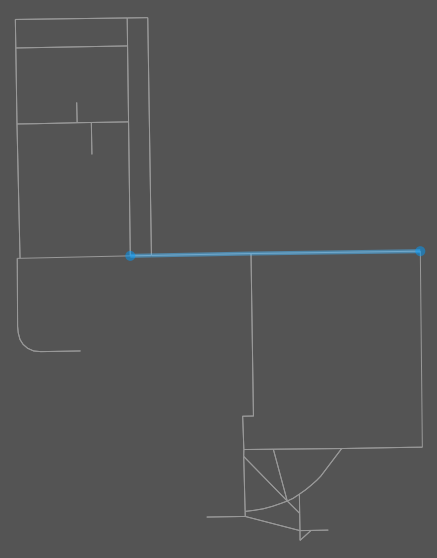

Head North onto South University Avenue
in 403.124 meters turn right onto East 55th Street
in 67.505 meters turn left
in 162.06 meters turn a slight left
in 163.36 meters you'll arrive at Hyde Park–Kenwood Historic District. Hyde Park–Kenwood Historic District is the name of the National Register of Historic Places (NRHP) district on the South Side of Chicago that includes parts of the Hyde Park and Kenwood community areas of Chicago, Illinois.  The northern part of this district overlaps with the officially designated Chicago Landmark Kenwood District. This northern part of the Hyde Park–Kenwood Historic District contains the Chicago home of Barack Obama. The entire district was added to the NRHP on February 14, 1979 and expanded on August 16, 1984 and May 16, 1986. The district is bounded to the north, south, east and west, respectively by 47th Street, 59th Street, Lake Park Avenue and Cottage Groves Avenue. Despite the large amount of property associated with the University of Chica

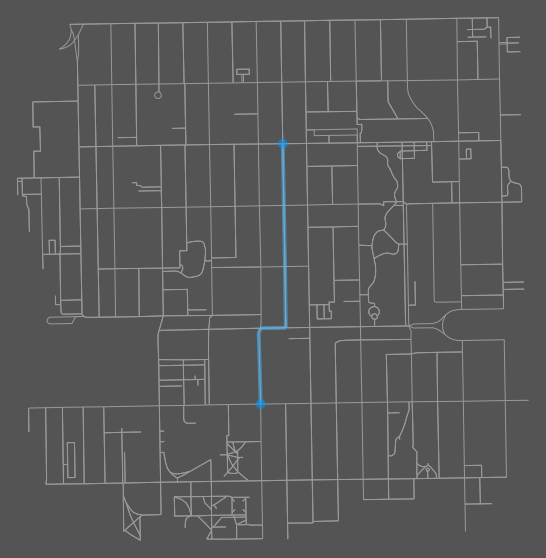

Head North onto nan
in 162.971 meters you'll arrive at Heller House. The Isidore H. Heller House is a house located at 5132 South Woodlawn Avenue in the Hyde Park community area of Chicago in Cook County, Illinois, United States. The house was designed by American architect Frank Lloyd Wright. The design is credited as one of the turning points in Wright's shift to geometric, Prairie School architecture, which is defined by horizontal lines, flat or hipped roofs with broad overhanging eaves, windows grouped in horizontal bands, and an integration with the landscape, which is meant to evoke native Prairie surroundings.
The work demonstrates Wright's shift away from emulating the style of his mentor, Louis Sullivan. Richard Bock, a Wright collaborator and sculptor, provided some of the ornamentation, including a plaster frieze. The ownership history of this building demonstrates the property's evolution and development in the framework of surrounding Hyde Park buildings, and the building

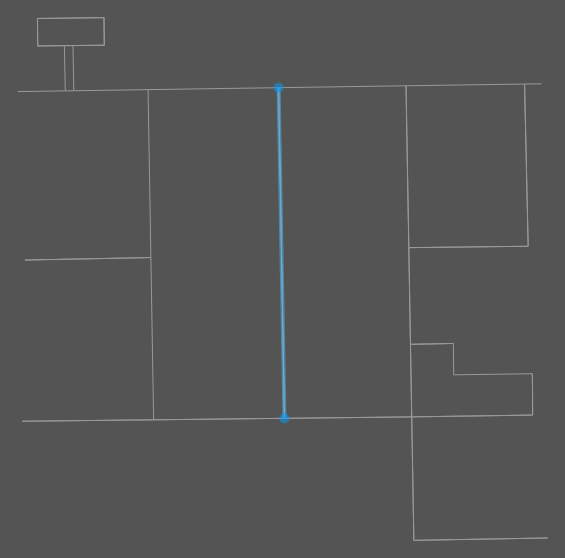

Head North onto nan
in 323.174 meters turn right onto East Hyde Park Boulevard
in 63.004 meters turn left onto South Woodlawn Avenue
in 71.783 meters turn right onto East Madison Park
in 407.703 meters turn right onto South Dorchester Avenue
in 73.671 meters turn left onto East Hyde Park Boulevard
in 336.144 meters turn left onto South Lake Park Avenue
in 858.51 meters turn right
in 41.897 meters you'll arrive at 47th Street (Kenwood) station. 47th Street (Kenwood) is a commuter rail  station within the city of Chicago that serves the Metra Electric Line north to Millennium Station and south to University Park, Blue Island, Illinois, and the neighborhood of South Chicago. This station is a flag stop  picking up passengers only when visible to train conductor and discharging passengers only when conductors are notified. Passengers can only exit the train from the first car.
The first station at this location was originally built by the Illinois Central railroad (ICRR).


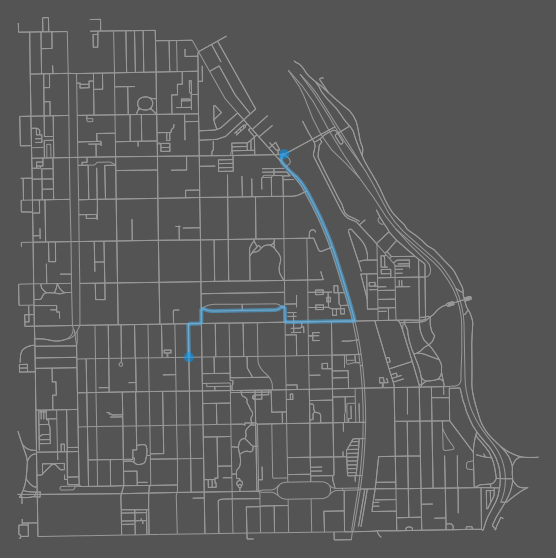

Head East onto East 47th Street
in 431.058 meters turn left
in 304.794 meters turn a slight right onto South Lake Shore Drive
in 5154.836 meters turn a slight right
in 348.627 meters turn left
in 93.962 meters turn a slight right
in 9.558 meters turn a slight left
in 23.163 meters you'll arrive at 18th Street station (Illinois). 18th Street station is a commuter rail station on the Near South Side of Chicago, at 18th Street near Calumet Avenue. It serves the Metra Electric Line north to Millennium Station and south to University Park, Blue Island, and South Chicago.  For many Metra Electric trains, this is a flag stop, and the train will only stop there if specifically requested by a passenger.The station is also occasionally served by trains of the South Shore Line to Gary and South Bend, Indiana, on an exceptional basis for Chicago Bears home games during football season.
The station was originally built by the Illinois Central Railroad (ICRR). The railroad was first built in 1907.


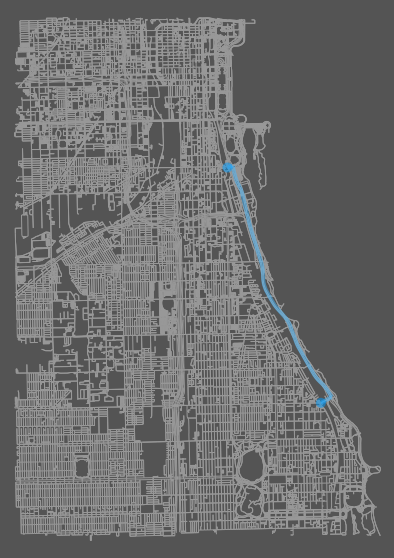

Head South onto South Mines Drive
in 141.412 meters turn right
in 88.46 meters turn right onto McCormick Place Busway
in 3115.274 meters turn right onto Lower Lower East Randolph Street
in 59.349 meters you'll arrive at Harris Theater (Chicago). The Joan W. and Irving B. Harris Theater for Music and Dance (also known as the Harris Theater for Music and Dance, the Harris & Harris Theater or, most commonly, the Harris Theater) is a 1,499-seat theater for the performing arts located along the northern edge of Millennium Park on Randolph Street in the Loop community area of Chicago in Cook County, Illinois, US. The theater, which is largely underground due to Grant Park-related height restrictions, was named for its primary benefactors, Joan and Irving Harris. It serves as the park's indoor performing venue, a complement to Jay Pritzker Pavilion, which hosts the park's outdoor performances.
Constructed in 2002–2003, it provides a venue for small and medium-sized music and dance groups, whi

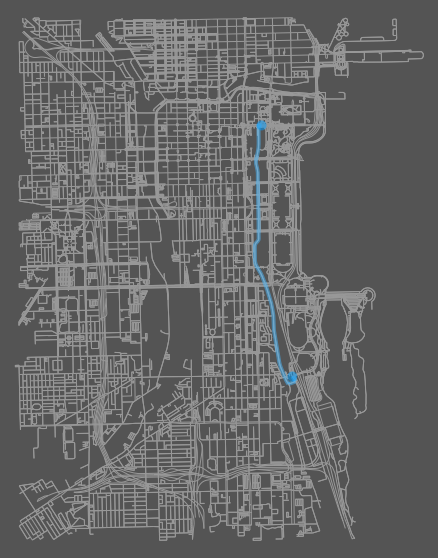

Head East onto Lower Lower East Randolph Street
in 56.319 meters you'll arrive at McDonald's Cycle Center. McDonald's Cycle Center (formerly Millennium Park Bike Station) is an indoor bike station in the northeast corner of Millennium Park in the Loop community area of Chicago, in the U.S. state of Illinois. The city of Chicago built the center at the intersection of East Randolph Street and Columbus Drive, and opened it July 2004. Since June 2006, it has been sponsored by McDonald's and several other partners, including city departments and bicycle advocacy organizations.  The bike station, which serves bicycle commuters and utility cyclists, provides lockers, showers, a snack bar with outdoor summer seating, bike repair, bike rental and 300 bicycle parking spaces. The Cycle Center is accessible by membership and day pass. It also accommodates runners and inline skaters, and provides space for a Chicago Police Department Bike Patrol Group.Planning for the Cycle Center was part of the 

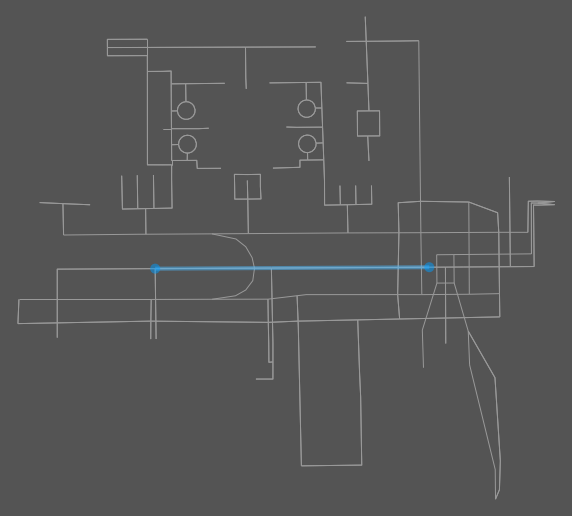

Head East onto Lower Lower East Randolph Street
in 17.849 meters turn left
in 159.188 meters turn left onto East Lake Street
in 6.143 meters turn left onto Middle North Columbus Drive
in 154.421 meters turn right onto Lower East Randolph Street
in 228.329 meters you'll arrive at One Prudential Plaza. One Prudential Plaza (formerly known as the Prudential Building) is a 41-story structure in Chicago completed in 1955 as the headquarters for Prudential's Mid-America company.  It was the first skyscraper built in Chicago since the Great Depression of the 1930s and the Second World War. The plaza, including a second building erected in 1990, is owned by BentleyForbes and a consortium of New York investors, since the Great Recession of the early 21st century.




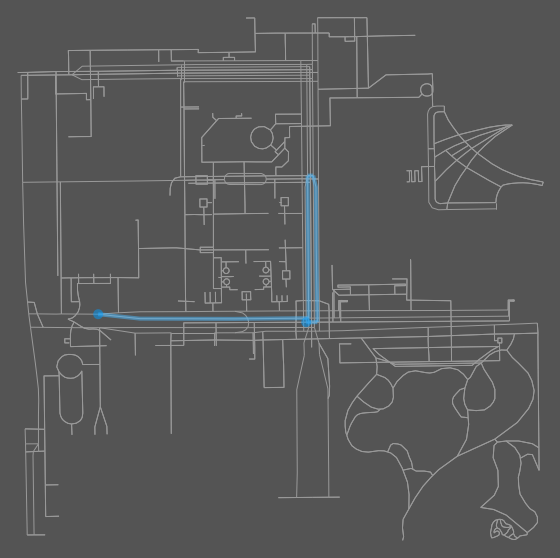

Head West onto East Randolph Street
in 105.821 meters turn left
in 15.941 meters turn left onto East Randolph Street
in 61.138 meters turn right onto Boeing Gallery North
in 39.854 meters you'll arrive at Union Base-Ball Grounds. Union Base-Ball Grounds was a baseball park located in Chicago. The park was "very visibly downtown", its small block bounded on the west by Michigan Avenue, on the north by Randolph Street, and on the east by railroad tracks and the lake shore, which was then much closer than it is today. The site is now part of Millennium Park. 




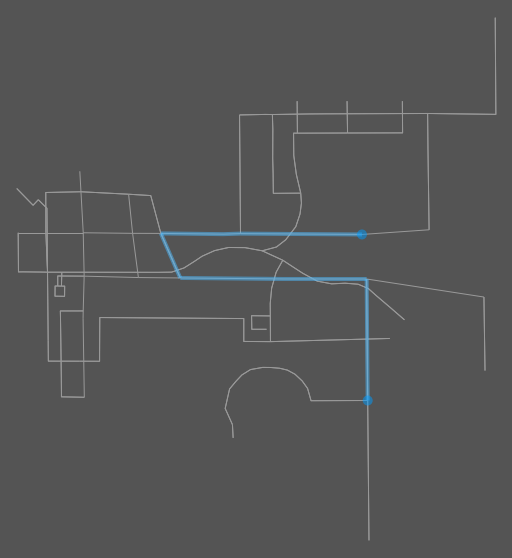

Head South onto Boeing Gallery North
in 45.881 meters you'll arrive at Wrigley Square. Wrigley Square is a public square located in the northwest section of Millennium Park in the Historic Michigan Boulevard District of the Loop area of Chicago in Cook County, Illinois, United States. The square is located at the southeast corner of the intersection of East Randolph Street and North Michigan Avenue. It contains the Millennium Monument, a nearly full-sized replica of the semicircle of paired Roman Doric-style columns (called a peristyle) that originally sat in this area of Grant Park, near Michigan Avenue and Randolph Street, between 1917 and 1953. The square also contains a large lawn and a public fountain.


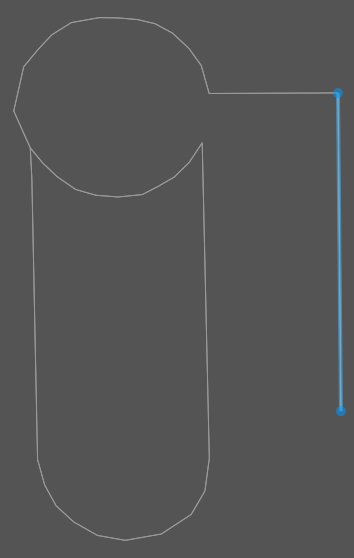

Head South onto Boeing Gallery North
in 30.941 meters you'll arrive at Cloud Gate. Cloud Gate is a public sculpture by Indian-born British artist Sir Anish Kapoor, that is the centerpiece of AT&T Plaza at Millennium Park in the Loop community area of Chicago, Illinois. The sculpture and AT&T Plaza are located on top of Park Grill, between the Chase Promenade and McCormick Tribune Plaza & Ice Rink. Constructed between 2004 and 2006, the sculpture is nicknamed The Bean because of its shape. Made up of 168 stainless steel plates welded together, its highly polished exterior has no visible seams. It measures 33 by 66 by 42 feet (10 by 20 by 13 m), and weighs 110 short tons (100 t; 98 long tons).
Kapoor's design was inspired by liquid mercury and the sculpture's surface reflects and distorts the city's skyline. Visitors are able to walk around and under Cloud Gate's 12-foot (3.7 m) high arch. On the underside is the "omphalos" (Greek for "navel"), a concave chamber that warps and multiplies

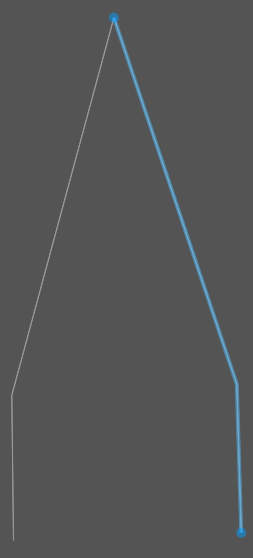

In [94]:
WikiRoute((41.792951, -87.599864),(41.882696, -87.623211),100)